<a href="https://colab.research.google.com/github/kvamsi7/mscs/blob/main/CS5720-Neural%20Network%20and%20Deep%20Learning/NN_Final_Project/NNDL_Project_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Restaurant_Reviews.tsv to Restaurant_Reviews.tsv


In [41]:
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load dataset
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t', quoting=3)


In [24]:
# Preprocess the text data

def pre_processing_text(data):
  corpus = []
  for i in range(len(data)):
      review = re.sub('[^a-zA-Z]', ' ', data[i])
      review = review.lower().split()
      review = [word for word in review if word not in set(stopwords.words('english'))]
      review = ' '.join(review)
      corpus.append(review)
  return corpus

corpus = pre_processing_text(dataset['Review'])
# Convert labels to binary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['Liked'])

# # Transform text data to numerical vectors
# cv = CountVectorizer(max_features=1500)
# X = cv.fit_transform(corpus).toarray()

array([0, 1])

In [6]:
max_features = 1500
max_len = 150
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)

X = pad_sequences(X,maxlen=max_len)

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # Reshape input data for LSTM
# X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [8]:
from keras.layers import Layer
import keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [10]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, 512,input_length = max_len))
lstm_model.add(LSTM(units=256, dropout=0.5,recurrent_dropout=0.2,return_sequences=True))
lstm_model.add(LSTM(units=196, dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
lstm_model.add(Attention())  # Add the custom attention layer after LSTM
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:

# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)


Epoch 1/25
25/25 [==============================] - 13s 319ms/step - loss: 0.6954 - accuracy: 0.5025
Epoch 2/25
25/25 [==============================] - 8s 311ms/step - loss: 0.6937 - accuracy: 0.5088
Epoch 3/25
25/25 [==============================] - 8s 308ms/step - loss: 0.6943 - accuracy: 0.4575
Epoch 4/25
25/25 [==============================] - 8s 309ms/step - loss: 0.6939 - accuracy: 0.4963
Epoch 5/25
25/25 [==============================] - 8s 309ms/step - loss: 0.6941 - accuracy: 0.5113
Epoch 6/25
25/25 [==============================] - 8s 308ms/step - loss: 0.6937 - accuracy: 0.5013
Epoch 7/25
25/25 [==============================] - 8s 308ms/step - loss: 0.6943 - accuracy: 0.4913
Epoch 8/25
25/25 [==============================] - 8s 306ms/step - loss: 0.6944 - accuracy: 0.5050
Epoch 9/25
25/25 [==============================] - 8s 308ms/step - loss: 0.6943 - accuracy: 0.4787
Epoch 10/25
25/25 [==============================] - 8s 308ms/step - loss: 0.6942 - accuracy: 0.491

In [12]:

# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM Test Accuracy:", lstm_accuracy)


7/7 [==============================] - 1s 93ms/step - loss: 0.6492 - accuracy: 0.7350
LSTM Test Accuracy: 0.7350000143051147


In [14]:
# Predict sentiment for a new review using both models
input_text = ['Place is good but the food is worst']
# input_vector = cv.transform(input_text).toarray()
input_vector_test = tokenizer.texts_to_sequences(input_text)

input_vector_seq = pad_sequences(input_vector_test,maxlen=max_len)

# LSTM model prediction
lstm_prediction = lstm_model.predict(input_vector_seq)[0][0]
if lstm_prediction >= 0.5:
    print('LSTM: Review is Positive')
else:
    print('LSTM: Review is Negative')

1/1 [==============================] - 0s 73ms/step
LSTM: Review is Positive


In [19]:
y_pred = np.array([1 if y_p > 0.5 else 0 for y_p in lstm_model.predict(X_test)])

7/7 [==============================] - 1s 92ms/step


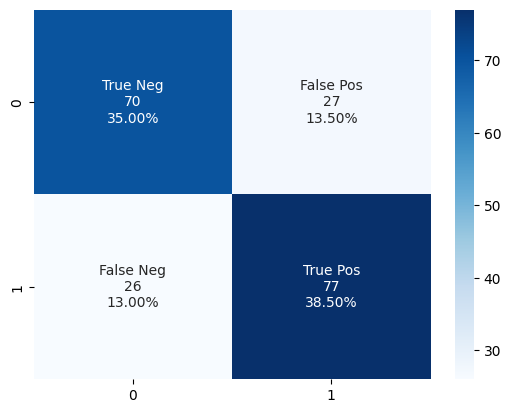

In [40]:
cf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.show()

In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73        97
           1       0.74      0.75      0.74       103

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200

